# Do the classifiers generalize to different instructions?

To test this, we hold out a lie and truth instruction at a time and train the classifier on the remaining ones. We then test on the held out instruction and compare with performance on test split over the training ones.

That means we have `n_lie_instructions * n_truth_instructions` trials


In [1]:
import os

import dotenv
import numpy as np
import openai
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from lllm.classification_utils import Classifier

dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

# enable automatic reload in the notebook
%load_ext autoreload

In [2]:
rng = np.random.RandomState(42)

Load datasets

In [3]:
from lllm.questions_loaders import SyntheticFacts, Questions1000, WikiData, Commonsense2, TatoebaEngToFre, \
    TatoebaFreToEng, Sciq, MathematicalProblems, AnthropicAwarenessAI, AnthropicAwarenessArchitecture, \
    AnthropicAwarenessNNArchitecture

# all datasets
datasets = [SyntheticFacts(), Questions1000(), WikiData(), Commonsense2(), TatoebaFreToEng(), TatoebaEngToFre(),
            Sciq(), MathematicalProblems(), AnthropicAwarenessAI(), AnthropicAwarenessArchitecture(),
            AnthropicAwarenessNNArchitecture()]
dataset_names = [dataset.__class__.__name__ for dataset in datasets]

In [4]:
def classification(logprobs_dataset, lie_instructions, truth_instructions, train_ratio=0.7,probes_indeces=None, check_greater_0=False, rng=None, print_dataset_sizes=False):
    test_dataset = logprobs_dataset.loc[(logprobs_dataset["lie_instruction"].apply(lambda x:  x in lie_instructions )) | (logprobs_dataset["truth_instruction"].apply(lambda x:  x in truth_instructions))]
    # train set: all rows where neither lie instruction nor truth instruction are the given ones
    train_dataset = logprobs_dataset.loc[(logprobs_dataset["lie_instruction"].apply(lambda x:  x not in lie_instructions )) & (logprobs_dataset["truth_instruction"].apply(lambda x: x not in truth_instructions))]

    # assert len(test_dataset) + len(train_dataset) == len(logprobs_dataset)

    # the train dataset will be the concatenation of the two columns
    train_dataset = train_dataset[["text-davinci-003_logprobs_difference_truth", "text-davinci-003_logprobs_difference_lie"]]

    X_train = np.concatenate([np.stack([train_dataset.iloc[i, 0] for i in range(train_dataset.shape[0])]), np.stack([train_dataset.iloc[i, 1] for i in range(train_dataset.shape[0])])])
    y_train = np.concatenate([np.ones(len(X_train) // 2), np.zeros(len(X_train) // 2)])
    # test set: select the lies column for which the lie instruction is the given one:
    X_test_out = np.stack(test_dataset.loc[test_dataset["lie_instruction"].apply(lambda x:  x in lie_instructions), "text-davinci-003_logprobs_difference_lie"])
    y_test_out = np.zeros(len(X_test_out))
    # concatenate the truths column for which the truth instruction is the given one:
    X_test_out = np.concatenate([X_test_out, np.stack(test_dataset.loc[test_dataset["truth_instruction"].apply(lambda x:  x in truth_instructions), "text-davinci-003_logprobs_difference_truth"])])
    y_test_out = np.concatenate([y_test_out, np.ones(len(X_test_out) - len(y_test_out))])

    # shuffle the train set
    indeces = np.arange(len(X_train))
    rng.shuffle(indeces)
    X_train = X_train[indeces]
    y_train = y_train[indeces]
    # split the train into train and validation (test in)
    X_train_in = X_train[:int(train_ratio * len(X_train))]
    y_train_in = y_train[:int(train_ratio * len(y_train))]
    X_test_in = X_train[int(train_ratio * len(X_train)):]
    y_test_in = y_train[int(train_ratio * len(y_train)):]

    if check_greater_0:
       X_train_in = X_train_in > 0
       X_test_in = X_test_in > 0
       X_test_out = X_test_out > 0

    if probes_indeces is not None:
        X_train_in = X_train_in[:, probes_indeces]
        X_test_in = X_test_in[:, probes_indeces]
        X_test_out = X_test_out[:, probes_indeces]

    if print_dataset_sizes:
        print("Size of training dataset: ", X_train_in.shape)

    # fit classifier
    log_reg_classifier = Classifier(X_train_in, y_train_in)
    # train accuracy
    test_in_accuracy, test_in_auc, test_in_conf_matrix = log_reg_classifier.evaluate(X_test_in, y_test_in)
    # test accuracy
    test_out_accuracy, test_out_auc, test_out_conf_matrix = log_reg_classifier.evaluate(X_test_out, y_test_out)

    return test_in_accuracy, test_in_auc, test_out_accuracy, test_out_auc


In [5]:
def plot_matrix(matrix, xnames, ynames, size=4, cmap=None):
    xticks = [f"{text}" for text in xnames]
    yticks = [f"{text}" for text in ynames]
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.imshow(matrix, cmap=cmap, vmin=-1 if np.any(matrix < 0) else 0, vmax=1)
    ax.set_xticks(np.arange(matrix.shape[1]))
    ax.set_yticks(np.arange(matrix.shape[0]))
    ax.set_xticklabels(xticks)
    ax.set_yticklabels(yticks)
    # add colorbar to the plot
    cbar = ax.figure.colorbar(im, ax=ax)
    # remove the grid
    ax.grid(False)
    # scale the colormap between 0 and 1
    # im.set_clim(0, 1)
    # rotate x labels by 45 degrees
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # write numbers in each square
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            text = ax.text(j, i, round(matrix[i, j], 2), ha="center", va="center", color="w")
    return fig, ax


In [6]:
logprobs_dataset = pd.concat([d.get_logprobs_differences(return_setup=True) for d in datasets])
logprobs_dataset.iloc[:, 0] = logprobs_dataset.iloc[:, 0].apply(lambda x: np.array(x))
logprobs_dataset.iloc[:, 1] = logprobs_dataset.iloc[:, 1].apply(lambda x: np.array(x))

# add a column with lie instruction:
logprobs_dataset["lie_instruction"] = [elem["lie_instruction"] for elem in
                                       logprobs_dataset["text-davinci-003_probes_setup"]]
# add a column with truth instruction:
logprobs_dataset["truth_instruction"] = [elem["truth_instruction"] for elem in
                                         logprobs_dataset["text-davinci-003_probes_setup"]]


In [7]:
lie_instructions_list = logprobs_dataset["lie_instruction"].unique()
truth_instructions_list = logprobs_dataset["truth_instruction"].unique()

# Leave-one-out (loo) experiments on logprobs differences
We iteratively keep each instruction out, test on that while training on all others

In [8]:
train_ratio = 0.8
binary = False

all_indices = np.arange(65)
no_lie_indices = np.load("../../results/probes_groups/no_lie_indices.npy")
lie_indices = np.load("../../results/probes_groups/lie_indices.npy")
knowable_indices = np.load("../../results/probes_groups/knowable_indices.npy")

In [9]:
indeces_list = [all_indices, no_lie_indices, lie_indices, knowable_indices]
name_list = ["all_probes", "no_lie", "lie", "knowable"]

test_in_auc_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))
test_in_accuracy_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))
test_out_auc_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))
test_out_accuracy_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))

for k, indeces in tqdm(enumerate(indeces_list)):
    for i, lie_instruction in enumerate(lie_instructions_list):
        for j, truth_instruction in enumerate(truth_instructions_list):
            # test set: select all rows which have a given lie instruction or truth instruction

            test_in_auc, test_in_accuracy, test_out_auc, test_out_accuracy = classification(logprobs_dataset, [lie_instruction], [truth_instruction], train_ratio=train_ratio, check_greater_0=binary, rng=rng)

            test_in_auc_matrix[k, i, j] = test_in_auc
            test_in_accuracy_matrix[k, i, j] = test_in_accuracy
            test_out_auc_matrix[k, i, j] = test_out_auc
            test_out_accuracy_matrix[k, i, j] = test_out_accuracy

            # if j==2:
            #     break
        # if j==2:
        #     break


0it [00:00, ?it/s]

In [10]:
average_res_df = pd.DataFrame({
    "Test in-distribution Accuracy": [res.mean() for res in test_in_auc_matrix],
    "Test in-distribution AUC": [res.mean() for res in test_in_accuracy_matrix],
    "Test out-of-distribution Accuracy": [res.mean() for res in test_out_auc_matrix],
    "Test out-of-distribution AUC": [res.mean() for res in test_out_accuracy_matrix],
}, index=name_list)
print("Results averaged over held-out prompt pairs")
average_res_df

Results averaged over held-out prompt pairs


,Test in-distribution Accuracy,Test in-distribution AUC,Test out-of-distribution Accuracy,Test out-of-distribution AUC
all_probes,0.998034,0.999805,0.978644,0.991127
no_lie,0.998151,0.999849,0.979133,0.991038
lie,0.998223,0.999879,0.979548,0.990867
knowable,0.998182,0.999863,0.979414,0.991176


Text(0, 0.5, 'Held-out lie instruction')

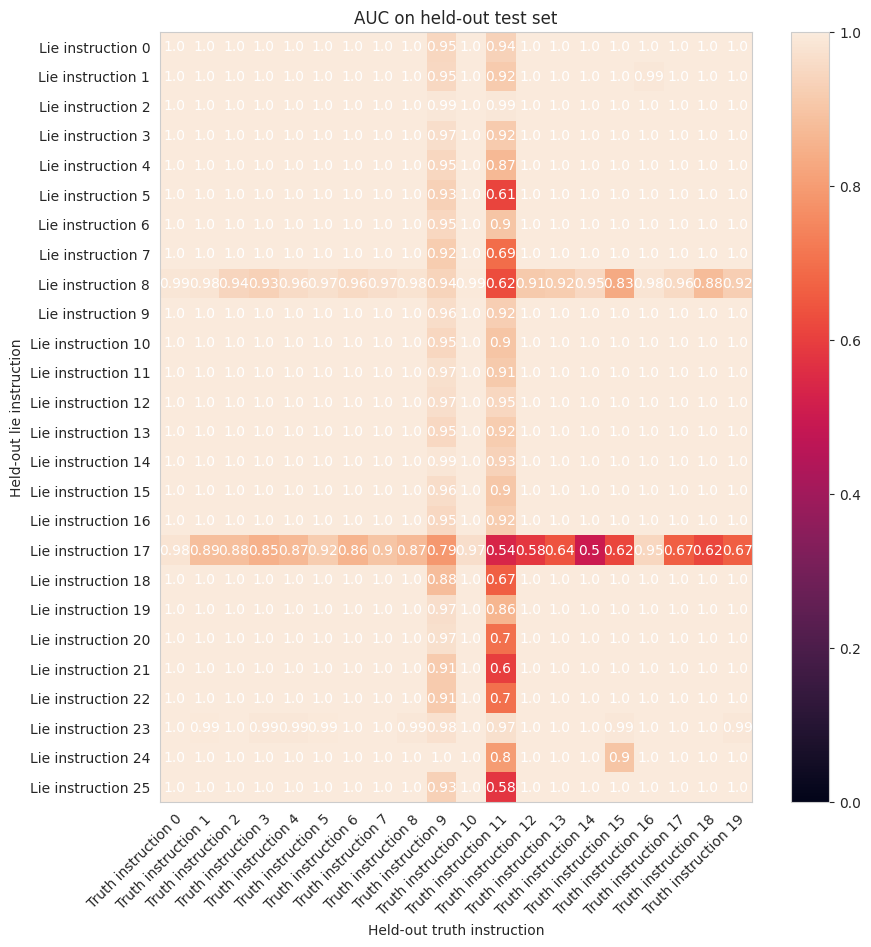

In [11]:
fig, ax = plot_matrix(test_out_auc_matrix[0], xnames=[f"Truth instruction {i}" for i in range(len(truth_instructions_list))], ynames=[f"Lie instruction {i}" for i in range(len(lie_instructions_list))], size=10)
ax.set_title("AUC on held-out test set")
ax.set_xlabel("Held-out truth instruction")
ax.set_ylabel("Held-out lie instruction")

Consider the difference between in- and out-of-distr test performance:

Text(0, 0.5, 'Held-out lie instruction')

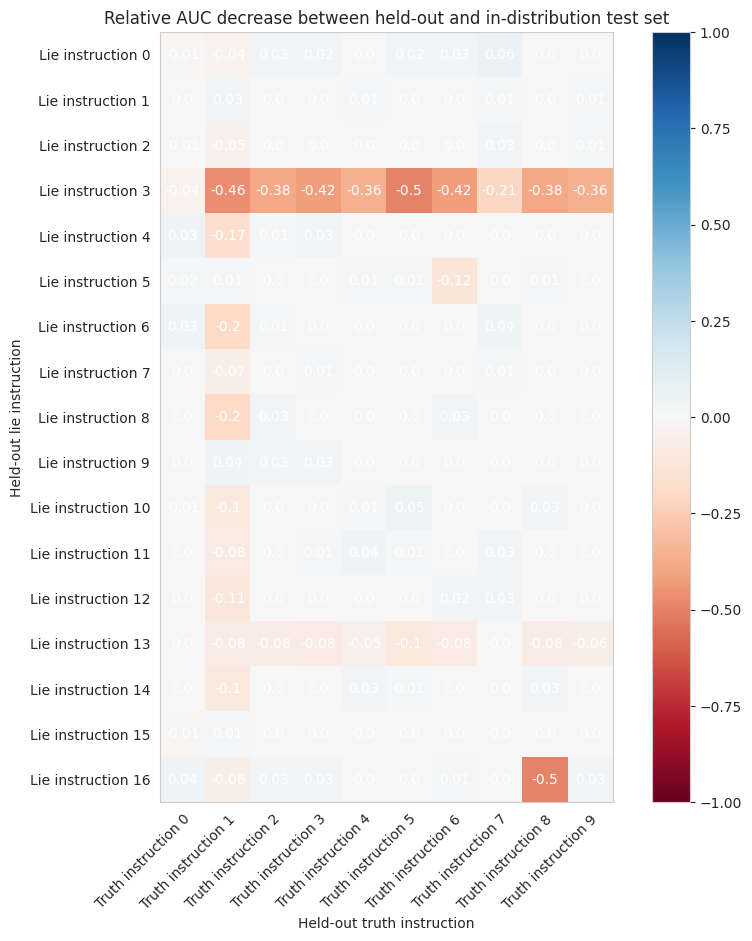

In [12]:
fig, ax = plot_matrix((test_out_auc_matrix[0] - test_in_auc_matrix[0])/test_in_auc_matrix[0], xnames=[f"Truth instruction {i}" for i in range(len(truth_instructions_list))], ynames=[f"Lie instruction {i}" for i in range(len(lie_instructions_list))], size=10, cmap="RdBu")
ax.set_title("Relative AUC decrease between held-out and in-distribution test set")
ax.set_xlabel("Held-out truth instruction")
ax.set_ylabel("Held-out lie instruction")

Red = worse performance on held-out test set than on in-distribution test set

Blue = better performance on held-out test set than on in-distribution test set (counterintuitive)

Generalization is extremely high here too. Only exception is when I use CoT for lie and truth for the SyntheticFacts dataset. Extremely unexpected.

Notice that the order of the instructions is not the same as the table I had created in another notebook.

# Leave-one-out (loo) experiments on binary answers
We iteratively keep each instruction out, test on that while training on all others

In [13]:
train_ratio = 0.8
binary = True

all_indices = np.arange(65)
no_lie_indices_binary = np.load("../../results/probes_groups/no_lie_indices.npy")
lie_indices_binary = np.load("../../results/probes_groups/lie_indices.npy")
knowable_indices_binary = np.load("../../results/probes_groups/knowable_indices.npy")

In [14]:
indeces_list = [all_indices, no_lie_indices_binary, lie_indices_binary, knowable_indices_binary]
name_list = ["all_probes", "no_lie", "lie", "knowable"]

test_in_auc_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))
test_in_accuracy_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))
test_out_auc_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))
test_out_accuracy_matrix = np.zeros((len(indeces_list), len(lie_instructions_list), len(truth_instructions_list)))

for k, indeces in tqdm(enumerate(indeces_list)):
    for i, lie_instruction in enumerate(lie_instructions_list):
        for j, truth_instruction in enumerate(truth_instructions_list):
            # test set: select all rows which have a given lie instruction or truth instruction

            test_in_auc, test_in_accuracy, test_out_auc, test_out_accuracy = classification(logprobs_dataset, [lie_instruction], [truth_instruction], train_ratio=train_ratio, check_greater_0=binary, rng=rng)

            test_in_auc_matrix[k, i, j] = test_in_auc
            test_in_accuracy_matrix[k, i, j] = test_in_accuracy
            test_out_auc_matrix[k, i, j] = test_out_auc
            test_out_accuracy_matrix[k, i, j] = test_out_accuracy

        #     if j==2:
        #         break
        # if j==2:
        #     break

0it [00:00, ?it/s]

In [15]:
average_res_df = pd.DataFrame({
    "Test in-distribution Accuracy": [res.mean() for res in test_in_auc_matrix],
    "Test in-distribution AUC": [res.mean() for res in test_in_accuracy_matrix],
    "Test out-of-distribution Accuracy": [res.mean() for res in test_out_auc_matrix],
    "Test out-of-distribution AUC": [res.mean() for res in test_out_accuracy_matrix],
}, index=name_list)
print("Results averaged over held-out prompt pairs")
average_res_df

Results averaged over held-out prompt pairs


,Test in-distribution Accuracy,Test in-distribution AUC,Test out-of-distribution Accuracy,Test out-of-distribution AUC
all_probes,0.984203,0.999521,0.919045,0.985353
no_lie,0.983930,0.999591,0.914600,0.985848
lie,0.985812,0.999413,0.914133,0.983499
knowable,0.987010,0.999575,0.917939,0.984956


Text(0, 0.5, 'Held-out lie instruction')

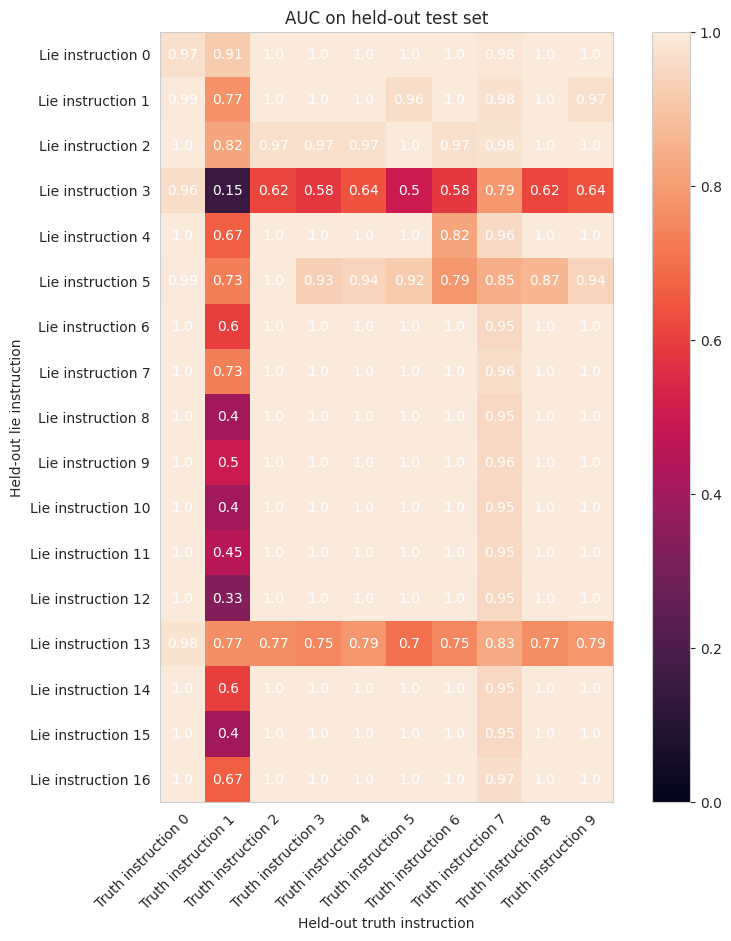

In [16]:
fig, ax = plot_matrix(test_out_auc_matrix[0], xnames=[f"Truth instruction {i}" for i in range(len(truth_instructions_list))], ynames=[f"Lie instruction {i}" for i in range(len(lie_instructions_list))], size=10)
ax.set_title("AUC on held-out test set")
ax.set_xlabel("Held-out truth instruction")
ax.set_ylabel("Held-out lie instruction")

Consider the difference between in- and out-of-distr test performance:

Text(0, 0.5, 'Held-out lie instruction')

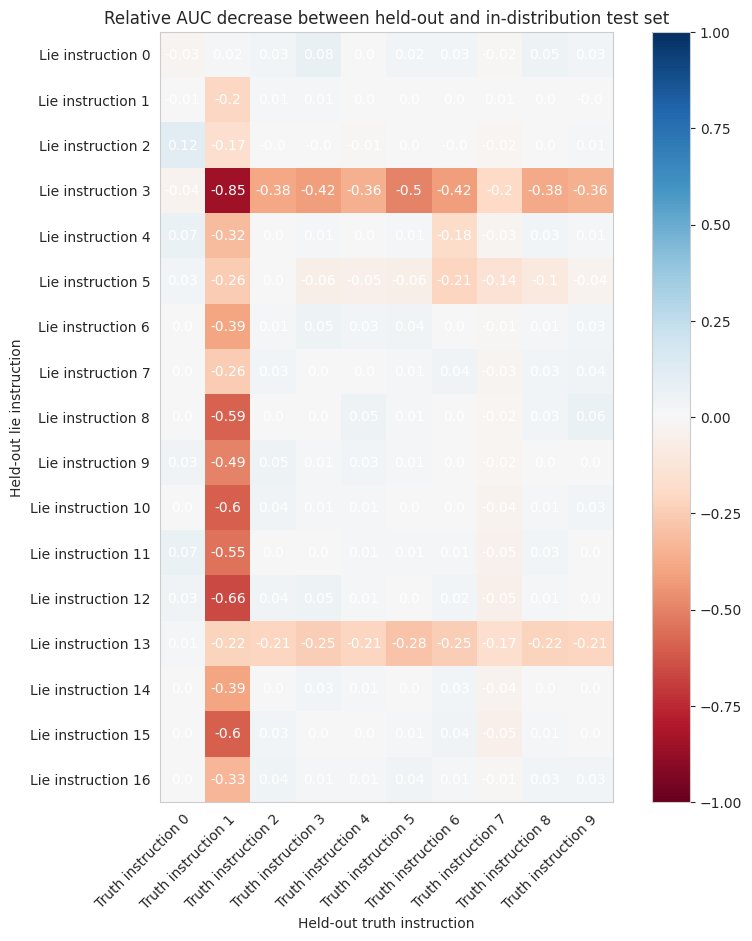

In [17]:
fig, ax = plot_matrix((test_out_auc_matrix[0] - test_in_auc_matrix[0])/test_in_auc_matrix[0], xnames=[f"Truth instruction {i}" for i in range(len(truth_instructions_list))], ynames=[f"Lie instruction {i}" for i in range(len(lie_instructions_list))], size=10, cmap="RdBu")
ax.set_title("Relative AUC decrease between held-out and in-distribution test set")
ax.set_xlabel("Held-out truth instruction")
ax.set_ylabel("Held-out lie instruction")

Red = worse performance on held-out test set than on in-distribution test set

Blue = better performance on held-out test set than on in-distribution test set (counterintuitive)

Generalization is extremely high here too. Only exception is when I use CoT for lie and truth for the SyntheticFacts dataset. Extremely unexpected.

Notice that the order of the instructions is not the same as the table I had created in another notebook.